In [1]:
import argparse
import os
os.umask(0)
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import pickle
import sys
from importlib import import_module

import torch
from torch.utils.data import DataLoader, Sampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm

from data import InteDataset
from data import ArgoTestDataset
from utils import Logger, load_pretrain

# define parser
parser = argparse.ArgumentParser(description="Argoverse Motion Forecasting in Pytorch")
parser.add_argument(
    "-m", "--model", default="lanegcn", type=str, metavar="MODEL", help="model name"
)
parser.add_argument("--eval", action="store_true", default=True)
parser.add_argument(
    "--split", type=str, default="val", help='data split, "val" or "test"'
)
parser.add_argument(
    "--weight", default="/media/drl/datas/zyk/LaneGCN/results/lanegcn_interaction/36.000.ckpt", type=str, metavar="WEIGHT", help="checkpoint path"
)
# parser.add_argument(
#     "--weight", default="/media/drl/datas/zyk/LaneGCN/results/lanegcn/17.000.ckpt", type=str, metavar="WEIGHT", help="checkpoint path"
# )


_StoreAction(option_strings=['--weight'], dest='weight', nargs=None, const=None, default='/media/drl/datas/zyk/LaneGCN/results/lanegcn_interaction/36.000.ckpt', type=<class 'str'>, choices=None, help='checkpoint path', metavar='WEIGHT')

In [2]:
root_path = '/media/drl/datas/zyk/LaneGCN'
sys.path.insert(0, root_path)

model = import_module("lanegcn")
config, _, collate_fn, net, loss, post_process, opt = model.get_model()


In [4]:
ckpt_path = "/media/drl/datas/zyk/LaneGCN/results/remote_lanegcn/9.000.ckpt"
# ckpt_path = "/media/drl/datas/zyk/LaneGCN/results/lanegcn/17.000.ckpt"

if not os.path.isabs(ckpt_path):
    ckpt_path = os.path.join(config["save_dir"], ckpt_path)
ckpt = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
load_pretrain(net, ckpt["state_dict"])
net.eval()


Net(
  (actor_net): ActorNet(
    (groups): ModuleList(
      (0): Sequential(
        (0): Res1d(
          (conv1): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (relu): ReLU(inplace=True)
          (bn1): GroupNorm(1, 32, eps=1e-05, affine=True)
          (bn2): GroupNorm(1, 32, eps=1e-05, affine=True)
          (downsample): Sequential(
            (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,), bias=False)
            (1): GroupNorm(1, 32, eps=1e-05, affine=True)
          )
        )
        (1): Res1d(
          (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (relu): ReLU(inplace=True)
          (bn1): GroupNorm(1, 32, eps=1e-05, affine=True)
          (bn2): GroupNorm(1, 32, eps=1e-05, affine=True)
        )
      )
    

In [30]:
dataset = InteDataset('/media/drl/datas/zyk/interaction_gyt/preprocess_results/val/')
data_loader = DataLoader(
    dataset,
    batch_size=config["val_batch_size"],
    num_workers=config["val_workers"],
    collate_fn=collate_fn,
    shuffle=True,
    pin_memory=True,
)

# begin inference
preds = {}
gts = {}
cities = {}
for ii, data in tqdm(enumerate(data_loader)):
    data = dict(data)
    with torch.no_grad():
        output = net(data)
        results = [x[0:1].detach().cpu().numpy() for x in output["reg"]]

    for i, pred_traj in enumerate(results):
        if i < 5:
            continue
        break
#         preds[argo_idx] = pred_traj.squeeze()
#         cities[argo_idx] = data["city"][i]
#         # cities[argo_idx] = "Test"

#         gts[argo_idx] = data["gt_preds"][i][0] if "gt_preds" in data else None

37it [00:38,  1.03s/it]


KeyboardInterrupt: 

In [12]:
pred_traj

array([[[[1039.1227 , 1007.90295],
         [1038.9523 , 1007.9358 ],
         [1038.7333 , 1007.90735],
         [1038.4629 , 1007.93756],
         [1038.1364 , 1007.91644],
         [1037.8401 , 1007.976  ],
         [1037.4542 , 1007.9412 ],
         [1037.1141 , 1007.99304],
         [1036.6594 , 1007.9571 ],
         [1036.327  , 1007.9759 ],
         [1035.8933 , 1007.9944 ],
         [1035.3793 , 1008.0359 ],
         [1034.876  , 1008.06213],
         [1034.3933 , 1008.09607],
         [1033.861  , 1008.07684],
         [1033.2937 , 1008.1398 ],
         [1032.6976 , 1008.2244 ],
         [1032.1023 , 1008.1791 ],
         [1031.5305 , 1008.2634 ],
         [1030.939  , 1008.3147 ],
         [1030.3165 , 1008.32733],
         [1029.617  , 1008.36816],
         [1028.9535 , 1008.3797 ],
         [1028.2651 , 1008.3851 ],
         [1027.5537 , 1008.4007 ],
         [1026.8662 , 1008.4009 ],
         [1026.083  , 1008.3843 ],
         [1025.3667 , 1008.44965],
         [1024.7454 

In [13]:
def traj_plot(traj, rot, orig, ax, c):

    
    if isinstance(traj, torch.Tensor):
        traj = traj.numpy()
    rot = rot.numpy()
    orig = orig.numpy()
    
    centerline = np.array([traj[:, 0] - orig[0], traj[:, 1] - orig[1]]).T
#     print(centerline)
    centerline = np.matmul(rot, (centerline.reshape(-1, 2)).T).T

    ax.plot(centerline[:, 0], centerline[:, 1], c)
    return centerline


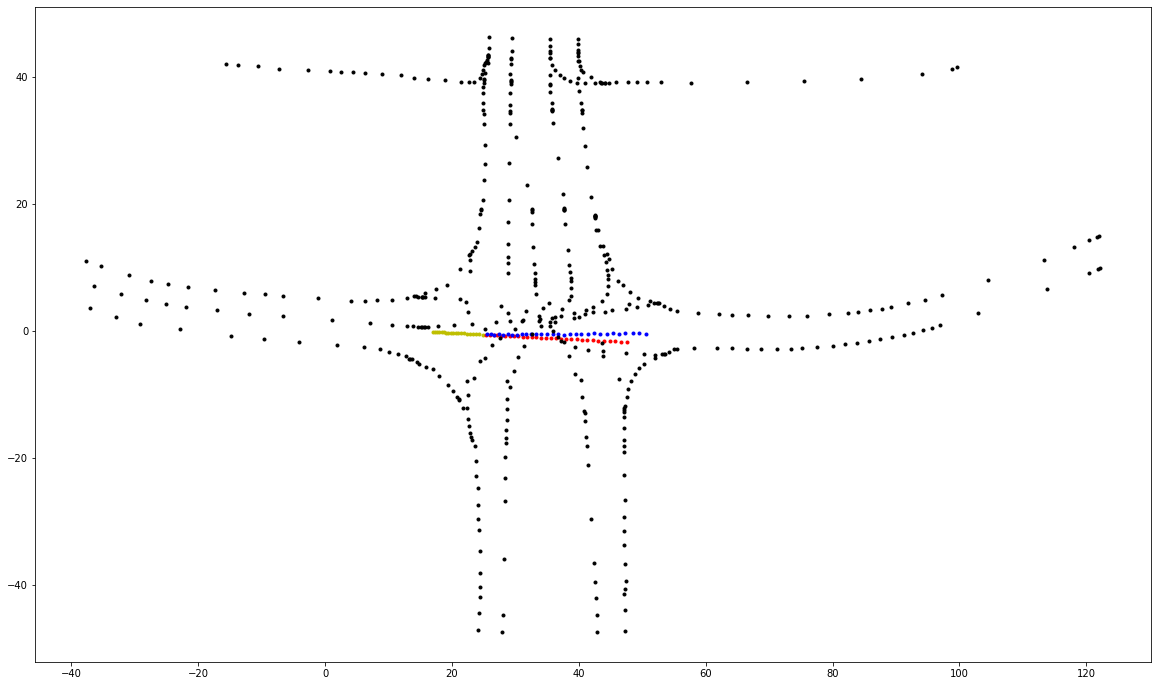

In [31]:
idx = 6
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(20,20))
ax.set_aspect('equal', adjustable='box')

orig = data['orig'][idx]
rot = data['rot'][idx]
graph = data['graph'][idx]
    
    
for a in range(data['gt_preds'][idx].shape[0]):
    if a is not 0:
        continue
    gt_preds = data['gt_preds'][idx][a]
    hist = data['feats'][idx][a]
    plt.plot(hist[:, 0], hist[:, 1], 'y.')
    traj_plot(gt_preds,  rot, orig, ax, 'r.')

# for k in range(results[idx].shape[1]):
k=0
pred_traj = results[idx][0, k, :, :]
traj_plot(pred_traj, rot, orig, ax, 'b.')
#     break


ctrs = graph['ctrs']
ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')

plt.show()

In [32]:
%%time
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.colors as colors

def create_animation():
  """ Creates a Matplotlib animation of the given images."""

  plt.ioff()
  fig, ax = plt.subplots()
  dpi = 100
  size_inches = 1000 / dpi
  fig.set_size_inches([size_inches, size_inches])
  plt.ion()

  ctrs = graph['ctrs']
  ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')
  pred_traj = results[idx][0, k, :, :]

  def animate_func(i):
    for a in range(data['gt_preds'][idx].shape[0]):
        gt_preds = data['gt_preds'][idx][a]
        hist = data['feats'][idx][a]
        if i < 20:
            ax.plot(hist[i, 0], hist[i, 1], 'y.')
        else:
            traj_plot(gt_preds[i-20:i-19],  rot, orig, ax, 'r.')
    
    if i >= 20 and results is not None:
        for k in range(6):
            traj_plot(results[idx][0, k, i-20:i-19, :], rot, orig, ax, 'b.')
        
        
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid('off')

  anim = animation.FuncAnimation(
      fig, animate_func, frames=50, interval=100)
  plt.close(fig)
  return anim


anim = create_animation()
HTML(anim.to_html5_video())

CPU times: user 3.34 s, sys: 56 ms, total: 3.39 s
Wall time: 3.57 s
